## the most of the codes are copied from https://github.com/snrazavi

In [2]:
%matplotlib inline

import warnings
import gzip, pickle
import numpy as np
import matplotlib.pyplot as plt


warnings.filterwarnings(action='ignore')                    

In [3]:
plt.rcParams['figure.figsize'] = (10,8)

np.random.seed(0)

In [4]:
DATA_PATH = 'Data/mnist.pkl.gz'

with gzip.open(DATA_PATH, 'rb') as f:
    (X_train, y_train), (X_valid, y_valid), (X_test, y_test) = pickle.load(f, encoding='latin')

print('Training data shape:    ', X_train.shape)
print('Training labels shape:  ', y_train.shape)
print('Validation data shape:  ', X_valid.shape)
print('Validation labels shape:', y_valid.shape)
print('Test data shape:        ', X_test.shape)
print('Test labels shape:      ', y_test.shape)

Training data shape:     (50000, 784)
Training labels shape:   (50000,)
Validation data shape:   (10000, 784)
Validation labels shape: (10000,)
Test data shape:         (10000, 784)
Test labels shape:       (10000,)


In [5]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict



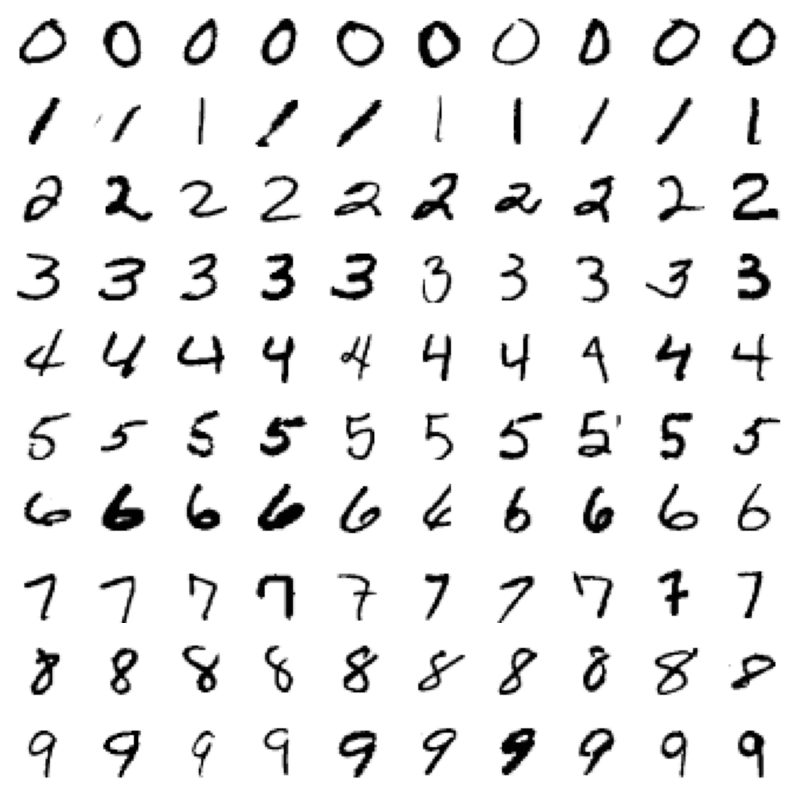

In [6]:
import matplotlib.pyplot as plt
import numpy as np

Classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# Create a figure with 10 rows and 10 columns
fig, axs = plt.subplots(10, 10, figsize=(10, 10))

for i, Y in enumerate(Classes):
    # Get indices of samples for the current class
    indices = np.where(y_train == int(Y))[0]

    # Choose 10 random samples for the current class
    random_indices = np.random.choice(indices, 10, replace=False)

    for j, idx in enumerate(random_indices):
        ax = axs[i, j]
        ax.imshow(X_train[idx].reshape(28, 28), cmap=plt.cm.Greys)
        ax.grid(False)
        ax.axis('off')

plt.show()


### Normalization of data

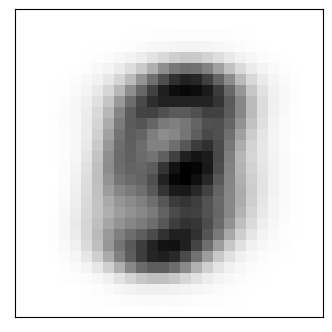

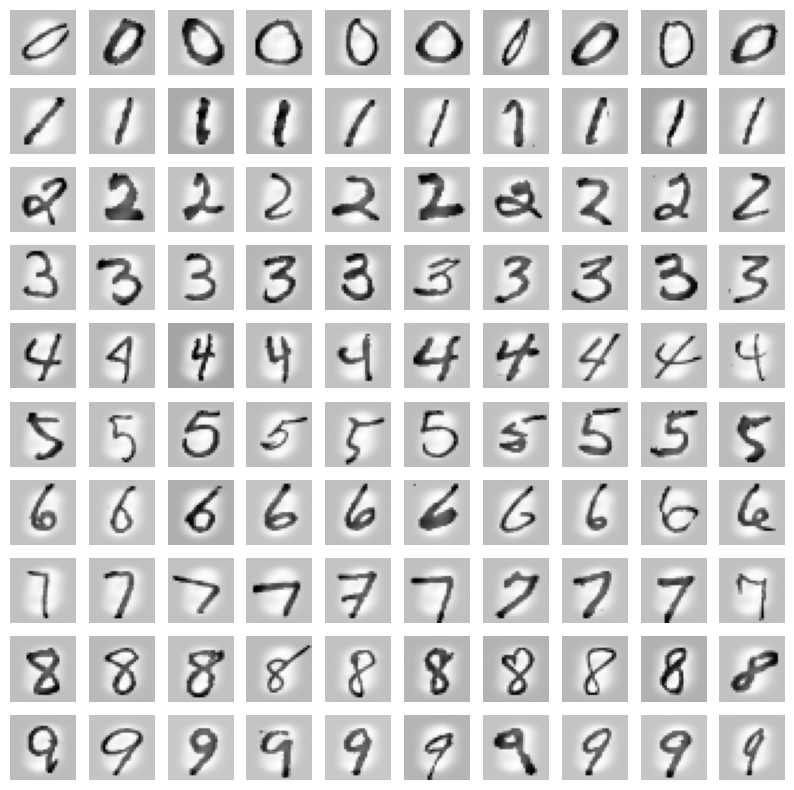

In [7]:
mu = np.mean(X_train, axis=0)
X_train -= mu
X_test -= mu
X_valid -= mu

plt.figure(figsize=(4, 4))
plt.imshow(mu.reshape(28,28), cmap=plt.cm.Greys)
plt.xticks([])
plt.yticks([])
plt.show()


Classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# Create a figure with 10 rows and 10 columns
fig, axs = plt.subplots(10, 10, figsize=(10, 10))

for i, Y in enumerate(Classes):
    # Get indices of samples for the current class
    indices = np.where(y_train == int(Y))[0]

    # Choose 10 random samples for the current class
    random_indices = np.random.choice(indices, 10, replace=False)

    for j, idx in enumerate(random_indices):
        ax = axs[i, j]
        ax.imshow(X_train[idx].reshape(28, 28), cmap=plt.cm.Greys)
        ax.grid(False)
        ax.axis('off')

plt.show()

### Random weighting of W

In [16]:
def predict(W, b, X):
    scores = X @ W + b
    return np.argmax(scores, axis=1)

def accuracy(y_pred, y_true):
    return 100. * np.mean(y_pred == y_true)

c = 10                # number of classes 
n = X_train.shape[1]  # number of features

# init parameters randomly
W = 0.01 * np.random.randn(n, c)
b = np.zeros(c)

# predict classes and compute accuracy
y_pred = predict(W, b, X_train)
acc = accuracy(y_pred, y_train)  # this function is defined in utils.py
print("Accuracy = {:.2f}%".format(acc))

Accuracy = 10.33%


### Loss Minimization using Sotmax Function and Gradien Decent

In [19]:
def softmax(x):
    x = x - np.max(x, axis=1, keepdims=True) 
    ### This subtraction of the maximum value helps prevent numerical overflow or instability that can occur when taking the exponential of large numbers.
    ### It is a common practice to improve the numerical stability of the softmax function, 
    ## which is often used in the output layer of neural networks for multi-class classification problems.
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def softmax_loss(W, b, X_batch, y_batch, mode='train'):
    bs = X_batch.shape[0]  # batch size
    
    scores = X_batch @ W + b
    probs = softmax(scores)
    loss = -np.sum(np.log(probs[range(bs), y_batch])) / bs
    
    if mode == 'test':
        return loss
    
    # compute gradients w.r.t scores
    dscores = np.copy(probs)
    dscores[range(bs), y_batch] -= 1.0
    dscores /= bs
    
    # compute gradients w.r.t W and b
    db = dscores.sum(axis=0)
    dW = X_batch.T @ dscores
    
    return loss, dW, db

In [20]:
def mini_batch_gradient_descent(X_train, y_train, X_valid, y_valid, batch_size=32, 
                                alpha=0.01, lmbda=1e-4, num_epochs=100):
    
    m, n = X_train.shape  #m: number of data, n: number of features
    num_batches = m % batch_size #number of batches
    
    report = "Epoch {:3d}: training loss = {:.2f} | validation loss = {:.2f}"
    
    # init parameters randomly
    W = np.random.randn(n, 10) * 0.001
    b = np.zeros((10,))
    
    for epoch in range(num_epochs):
        train_loss = 0.
        
        for batch in range(num_batches):
            
            # select a random mini-batch
            idx = np.random.choice(m, batch_size, replace=False)
            X_batch, y_batch = X_train[idx], y_train[idx]
            
            # compute loss and gradient
            loss, dW, db = softmax_loss(W, b, X_batch, y_batch)  # data loss
            loss += 0.5 * lmbda * np.sum(W ** 2)                 # regularization loss
            dW += lmbda * W
            
            train_loss += loss
            
            # update parameters            
            b = b - alpha * db
            W = W - alpha * dW
        
        # report stats after each epoch
        #train_loss /= num_batches        
        valid_loss = softmax_loss(W, b, X_valid, y_valid, mode='test')
        print(report.format(epoch+1, train_loss, valid_loss))
    
    return W, b

In [21]:
# hyper-parameters
alpha = 1e-1
lmbda = 1e-30
batch_size = 256
num_epochs = 200

# run mini-batch gradient descent
W, b = mini_batch_gradient_descent(X_train, y_train, X_valid, y_valid, 
                                   batch_size=batch_size, alpha=alpha,
                                   lmbda=lmbda, num_epochs=num_epochs)

Epoch   1: training loss = 83.37 | validation loss = 0.62
Epoch   2: training loss = 47.18 | validation loss = 0.48
Epoch   3: training loss = 40.78 | validation loss = 0.43
Epoch   4: training loss = 36.35 | validation loss = 0.40
Epoch   5: training loss = 34.40 | validation loss = 0.38
Epoch   6: training loss = 33.07 | validation loss = 0.37
Epoch   7: training loss = 31.75 | validation loss = 0.36
Epoch   8: training loss = 31.05 | validation loss = 0.35
Epoch   9: training loss = 30.40 | validation loss = 0.34
Epoch  10: training loss = 29.22 | validation loss = 0.34
Epoch  11: training loss = 29.27 | validation loss = 0.33
Epoch  12: training loss = 28.85 | validation loss = 0.33
Epoch  13: training loss = 28.13 | validation loss = 0.33
Epoch  14: training loss = 27.38 | validation loss = 0.32
Epoch  15: training loss = 26.63 | validation loss = 0.32
Epoch  16: training loss = 27.06 | validation loss = 0.32
Epoch  17: training loss = 27.43 | validation loss = 0.32
Epoch  18: tra

In [22]:
train_acc = accuracy(predict(W, b, X_train), y_train)
valid_acc = accuracy(predict(W, b, X_valid), y_valid)
test_acc = accuracy(predict(W, b, X_test), y_test)

print('Training accuracy =   {:.2f}%'.format(train_acc))
print('Validation accuracy = {:.2f}%'.format(valid_acc))
print('Test accuracy = {:.2f}%'.format(test_acc))

Training accuracy =   92.67%
Validation accuracy = 92.76%
Test accuracy = 92.27%


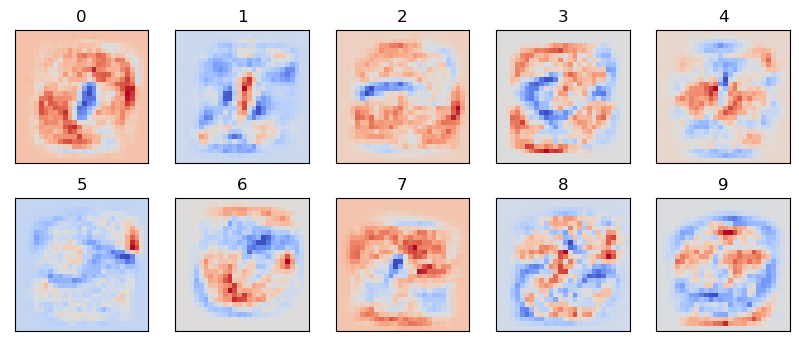

In [24]:
plt.figure(figsize=(10, 4))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(W[:, i].reshape((28, 28)), cmap=plt.cm.coolwarm)
    plt.xticks([])
    plt.yticks([])
    plt.title("%d" % i)
plt.show()

### Nonlinear Classification
#### TwoLayerNeuralNetwork

In [30]:
def softmax_loss_2(scores, y, mode='train'):
    m = scores.shape[0] #number of data
    probs = softmax(scores)
    loss = -np.sum(np.log(probs[range(m), y])) / m
    
    if mode != 'train':
        return loss
    
    # backward
    dscores = probs
    dscores[range(m), y] -= 1.0
    dscores /= m
    
    return loss, dscores

class TwoLayerNeuralNetwork:
    
    def __init__(self, num_features=784, num_hiddens=20, num_classes=10):
        self.num_hiddens = num_hiddens
        self.num_classes = num_classes
        
        # random initialization: create random weights, set all biases to zero
        self.params = {}
        self.params['W1'] = np.random.randn(num_features, num_hiddens) * 0.001
        self.params['W2'] = np.random.randn(num_hiddens,  num_classes) * 0.001
        self.params['b1'] = np.zeros((num_hiddens,))
        self.params['b2'] = np.zeros((num_classes,))
        
    def forward(self, X):
        # forward step
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        
        # forward step
        h_in = X @ W1 + b1       # hidden layer input
        h = np.maximum(0, h_in)  # hidden layer output (using ReLU)
        scores = h @ W2 + b2     # neural net output
        
        return scores
                            
    def train_step(self, X, y):
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        
        # forward step
        h_in = X @ W1 + b1       # hidden layer input
        h = np.maximum(0, h_in)  # hidden layer output (using ReLU)
        scores = h @ W2 + b2     # neural net output
        
        # compute loss
        loss, dscores = softmax_loss_2(scores, y)
        
        # backward step
        db2 = dscores.sum(axis=0)
        dW2 = h.T @ dscores
        
        dh = dscores @ W2.T
        dh[h_in < 0] = 0.0
        db1 = dh.sum(axis=0)
        dW1 = X.T @ dh
        
        gradient = {'W1': dW1, 'b1': db1, 'W2': dW2, 'b2': db2}
                
        return loss, gradient
        
    def train(self, X_train, y_train, X_valid, y_valid, batch_size=50, 
              alpha=0.001, lmbda=0.0001, num_epochs=20):
        
        m, n = X_train.shape        
        num_batches = m // batch_size
        
        report = "{:3d}: training loss = {:.2f} | validation loss = {:.2f}"
        
        losses = []
        for epoch in range(num_epochs):
            train_loss = 0.0
            
            for _ in range(num_batches):
                W1, b1 = self.params['W1'], self.params['b1']
                W2, b2 = self.params['W2'], self.params['b2']
                
                # select a random mini-batch
                batch_idx = np.random.choice(m, batch_size, replace=False)
                X_batch, y_batch = X_train[batch_idx], y_train[batch_idx]

                # train on mini-batch
                data_loss, gradient = self.train_step(X_batch, y_batch)
                reg_loss = 0.5 * (np.sum(W1 ** 2) + np.sum(W2 ** 2))
                train_loss += (data_loss + lmbda * reg_loss)
                losses.append(data_loss + lmbda * reg_loss)

                # regularization
                gradient['W1'] += lmbda * W1
                gradient['W2'] += lmbda * W2

                # update parameters
                for p in self.params:
                    self.params[p] = self.params[p] - alpha * gradient[p]
            
            # report training loss and validation loss
            train_loss /= num_batches
            valid_loss = softmax_loss_2(self.forward(X_valid), y_valid, mode='test')
            print(report.format(epoch + 1, train_loss, valid_loss))
        
        return losses
    
    def predict(self, X):
        """ Predict labels for input data.
        """
        scores = self.forward(X)
        return np.argmax(scores, axis=1)
    
    def predict_proba(self, X):
        """ Predict probabilties of classes for each input data.
        """
        scores = self.forward(X)
        return softmax(scores)

In [38]:
mlp = TwoLayerNeuralNetwork(num_hiddens=40)
losses = mlp.train(X_train, y_train, X_valid, y_valid, 
                   alpha=0.1, lmbda=0.001, num_epochs=30)

  1: training loss = 0.81 | validation loss = 0.28
  2: training loss = 0.29 | validation loss = 0.22
  3: training loss = 0.26 | validation loss = 0.18
  4: training loss = 0.22 | validation loss = 0.16
  5: training loss = 0.21 | validation loss = 0.15
  6: training loss = 0.20 | validation loss = 0.14
  7: training loss = 0.19 | validation loss = 0.13
  8: training loss = 0.19 | validation loss = 0.13
  9: training loss = 0.19 | validation loss = 0.12
 10: training loss = 0.18 | validation loss = 0.12
 11: training loss = 0.18 | validation loss = 0.11
 12: training loss = 0.18 | validation loss = 0.12
 13: training loss = 0.18 | validation loss = 0.11
 14: training loss = 0.17 | validation loss = 0.11
 15: training loss = 0.17 | validation loss = 0.11
 16: training loss = 0.17 | validation loss = 0.11
 17: training loss = 0.17 | validation loss = 0.11
 18: training loss = 0.17 | validation loss = 0.11
 19: training loss = 0.17 | validation loss = 0.10
 20: training loss = 0.17 | val

In [39]:
train_acc = accuracy(mlp.predict(X_valid), y_valid)
print("Validation accuracy   = {:.2f}%".format(train_acc))

test_acc = accuracy(mlp.predict(X_test), y_test)
print("Test accuracy = {:.2f}%".format(test_acc))

Validation accuracy   = 97.29%
Test accuracy = 97.22%


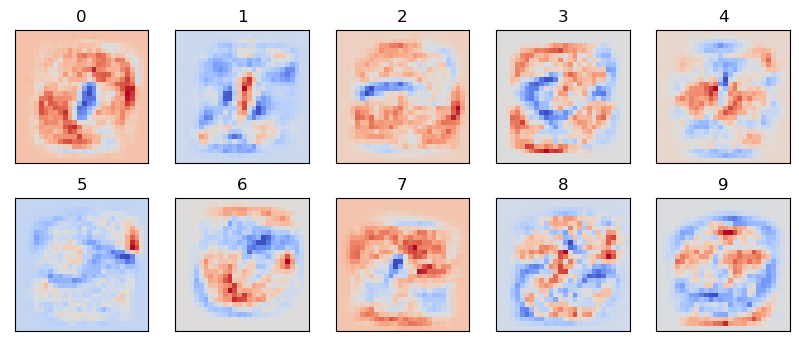

In [41]:
plt.figure(figsize=(10, 4))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(W[:, i].reshape((28, 28)), cmap=plt.cm.coolwarm)
    plt.xticks([])
    plt.yticks([])
    plt.title("%d" % i)
plt.show()

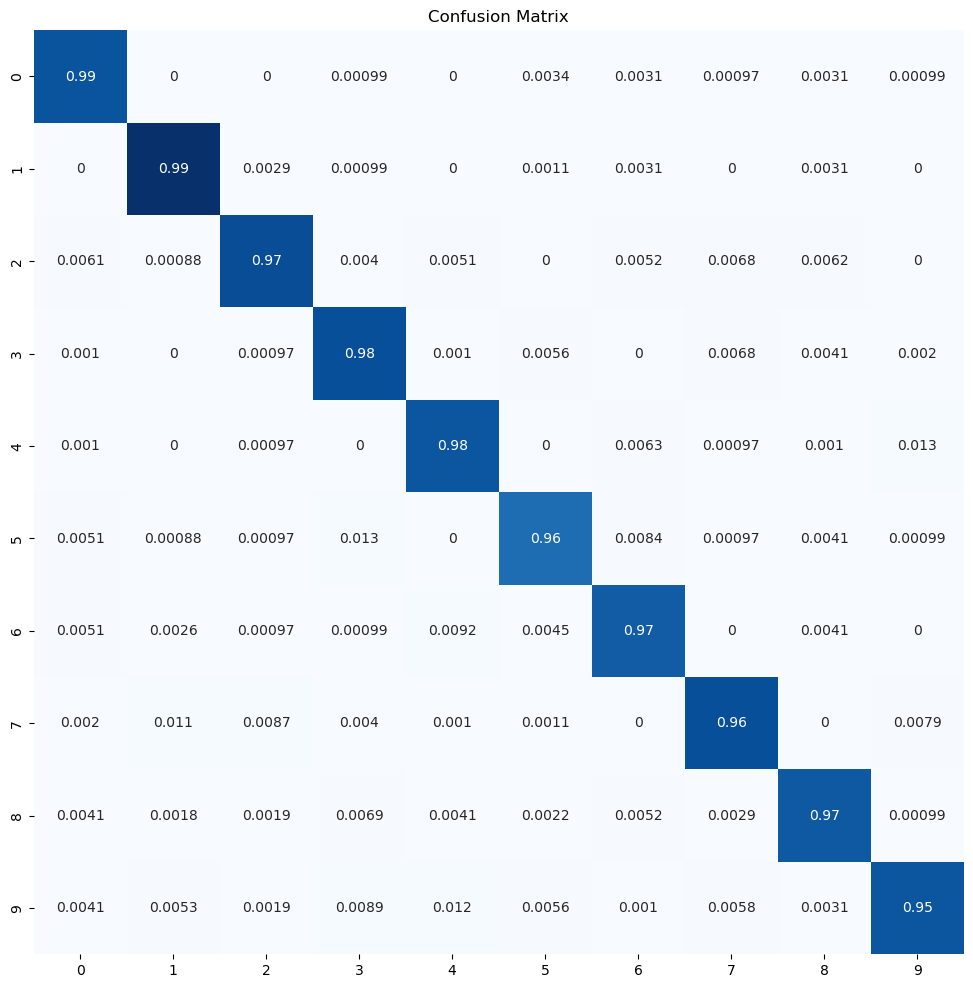

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, normalize=False, figsize=(12, 12)):
    cm = confusion_matrix(y_true, y_pred, labels=range(10))
    plt.figure(figsize=figsize)
    annot = cm/cm.sum(axis=1) if normalize else True
    sns.heatmap(cm, annot=annot, cmap=plt.cm.Blues, cbar=False)
    plt.title("Confusion Matrix")
    plt.show()

y_pred = mlp.predict(X_test)
plot_confusion_matrix(y_test, y_pred, normalize=True)

## Using SKLEARN

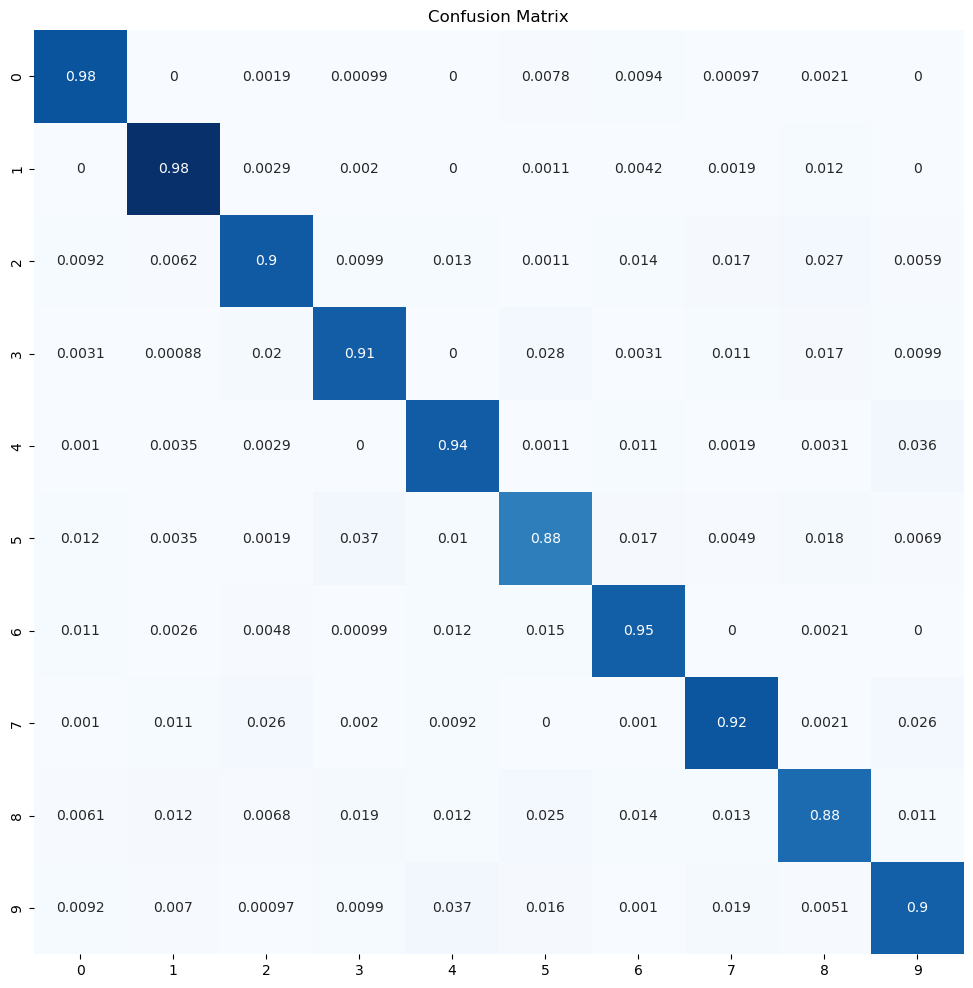

In [43]:

from sklearn.neural_network import MLPClassifier
model = MLPClassifier(hidden_layer_sizes=(20,), solver='sgd', learning_rate='adaptive',alpha=1.0, max_iter=40)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
plot_confusion_matrix(y_test, y_pred, normalize=True)

### Applying to moon dataset

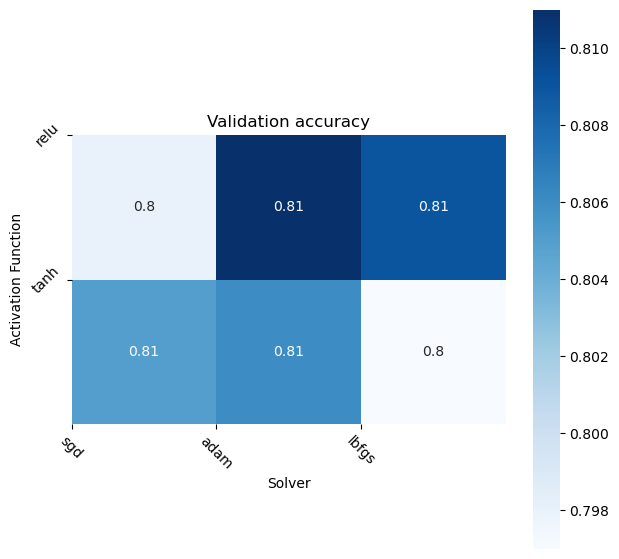

The best parameters are {'activation': 'relu', 'solver': 'adam'} with a score of 0.81


In [44]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.datasets import make_moons

# Generate synthetic data
X_moon, y_moon = make_moons(n_samples=1000, noise=0.5, random_state=0)

# Split data into train and validation
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Specify range of hyperparameters
activation_func = ['relu', 'tanh']
solver_range = ['sgd', 'adam', 'lbfgs']
param_grid = dict(solver=solver_range, activation=activation_func)

# Create classifier
grid = GridSearchCV(MLPClassifier(), param_grid=param_grid, cv=cv)
# Train
grid.fit(X_moon, y_moon)

# Visualize the results using a heatmap
scores = grid.cv_results_['mean_test_score'].reshape( len(activation_func), len(solver_range))

plt.figure(figsize=(7, 7))
sns.heatmap(scores, annot=True, cmap='Blues', square=True)

plt.xlabel('Solver')
plt.ylabel('Activation Function')
plt.xticks(np.arange(len(solver_range)), solver_range, rotation=-45)
plt.yticks(np.arange(len(activation_func)), activation_func, rotation=45)
plt.title('Validation accuracy')
plt.show()

print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))
